In [59]:
#importing functions 
import numpy as np
import matplotlib.pyplot as plt
import pycce as pc 
import pandas as pd
from scipy.optimize import curve_fit 
import mpi4py

In [60]:
# #define function to converge parameters
# def runner(variable, values, pulse_sequence, magnetic_field=[0,0,10000],nb=10):
#     print('Running:' + str(variable))
#     invalue = parameters[variable]
#     calc = pc.Simulator(spin=cen, bath=atoms, **parameters)
#     ls = []
#     abs_ls = []
    
#     for idx, v in enumerate(values):
#         print("Progress: " + str(idx/len(values)*100) + "%")
#         setattr(calc, variable, v)
#         l = calc.compute(ts, method='cce',
#                          pulses=pulse_sequence,
#                          nbstates=nb,
#                          quantity='coherence',
#                          parallel = True,
#                          parallel_states=True,
#                          magnetic_field=magnetic_field,)
        
        
#         #print('a run done') # uncomment to see progress
#         ls.append(l.real)
#         abs_ls.append(np.abs(l))

#     parameters[variable] = invalue
#     ls = pd.DataFrame(ls, columns=ts, index=values).T
#     abs_ls = pd.DataFrame(abs_ls, columns=ts, index=values).T
#     return abs_ls

# Function to set up Simulator:
def Setup_Simulator(cen, atoms, order, r_bath, r_dipole, pulses, magnetic_field):
    calc = pc.Simulator(spin=cen, bath=atoms, order=order, r_bath=r_bath, r_dipole=r_dipole, pulses=pulses, magnetic_field=magnetic_field)
    return calc

# Function to run Calculations:
def Run_Calculation(calc, timespace, method, pulses, nb_states, quantity, parallel, parallel_states):
    l = calc.compute(timespace=timespace, method=method, pulses=pulses, nbstates=nb_states, quantity=quantity, parallel=parallel, parallel_states=parallel_states)
    l_real = l.real
    l_abs = np.abs(l)
    return l_real

In [61]:
def Setup_Bath(concentration, cell_size, displacement, seed=8000):
    #import xyz file
    uc = pd.read_csv('VOTPP_opt.xyz', skiprows=2, header=None, delimiter='      ', engine='python') #enter specific directory
    #seperate columns into numpy arrays
    N = np.array(uc[0])
    x = np.array(uc[1])
    y = np.array(uc[2])
    z = np.array(uc[3])
    #set up unit cell
    sic = pc.BathCell(13.2613, 13.2613, 9.6851, 90, 90, 90, 'deg') #used optimized structure note there is also an x-ray structure with slightly different values
    # z axis in cell coordinates
    sic.zdir = [0, 0, 1]

    if concentration == 0:
        #populate cell
        for i in range(len(N)):
            sic.add_atoms((N[i], [x[i], y[i], z[i]]), type='angstrom')

        #assign position of qubit 
        # pos1 = x[76], y[76], z[76]
        # pos2 = x[76], y[76], z[77]
        pos2 = x[76], y[76], z[76] # Position of the nuclear spin
        pos1 = x[76]+displacement, y[76]+displacement, z[76]+displacement # Position of the electron spin (displacement is in angstroms)
        qpos1 = sic.to_cell(pos1)
        qpos2 = sic.to_cell(pos2)
        # print(qpos1)
        # print("")
        # print(qpos2)

        #generate supercell - nuclear bath 
        cell=cell_size
        atoms = sic.gen_supercell(cell, seed=seed, remove=[('V', qpos1)]) #left fixed for convergence tests to avoid changes
        #set          spin | gyro | quadrupole 
        spin_types = [('C',  1 / 2,  6.72828),    
                    ('H', 1 / 2, 26.7522),
                    ('N', 1, 1.9331, 20.44 )
                    #('V', 7/2, 7.05, -350)  # not added for consistency between tests
                    ]   
        atoms.add_type(*spin_types)
    
    if concentration > 0:
        x = np.array(x)

        #setting concentration
        sic.isotopes['V']['51V'] = concentration

        #populate unit cell with V
        sic.add_atoms((N[76], [x[76], y[76], z[76]]), type='angstrom')

        #assign position of qubit 
        # pos1 = x[76], y[76], z[76]
        # pos2 = x[76], y[76], z[77]
        pos1 = x[76], y[76], z[76] # Position of the nuclear spin
        pos2 = x[76]+displacement, y[76]+displacement, z[76]+displacement # Position of the electron spin (displacement is in angstroms)
        qpos1 = sic.to_cell(pos1)
        qpos2 = sic.to_cell(pos2)
        # print(qpos1)
        # print("")
        # print(qpos2)

        #generate supercell - nuclear bath 
        cell=cell_size


        atoms = sic.gen_supercell(cell, seed=seed, remove=[('V', qpos1), ('V', qpos2)]) #generate supercell 
        #set          spin | gyro | quadrupole 
        spin_types = ['51V',  1/2, -17608.59705]   #electronic bath
        atoms.add_type(*spin_types)
    
    return atoms, qpos1, qpos2


In [62]:
# def Setup_Center():
#     #set up the center 
#     cen = pc.CenterArray(position=[qpos1, qpos2], 
#                         spin=[1/2, 7/2], 
#                         gyro=[-17608.59705, -7.05], 
#                         D=[0, -350], 
#                         alpha= [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0], beta=[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
#     return cen

def Setup_Center(position, spin, gyro, D, alpha, beta):
    #set up the center 
    cen = pc.CenterArray(size=2, position=position, spin=spin, gyro=gyro, D=D, alpha=alpha, beta=beta)
    return cen

In [63]:
def Create_Interaction_Tensor(cen, printing=False):
    cen.point_dipole()

    el_alpha = np.array([0,1])
    el_beta = np.array([1,0])
    n_alpha = np.array([0,0,0,0,0,1,0,0])
    n_beta = np.array([0,0,0,0,1,0,0,0])

    # cen[0].alpha = el_alpha
    # cen[0].beta = el_beta
    # cen[1].alpha = n_alpha
    # cen[1].beta = n_beta
    cen[0].alpha = n_alpha
    cen[0].beta = n_beta
    cen[1].alpha = el_alpha
    cen[1].beta = el_beta

    # Generate product state
    # state = pc.normalize(np.kron(el_alpha + el_beta, n_alpha + n_beta)) # I'm kinda guessing the order here # This is performing a tensor product! (Kronecker product)
    state = pc.normalize(np.kron(el_beta + el_alpha, n_beta + n_alpha)) # I'm kinda guessing the order here # This is performing a tensor product! (Kronecker product)
    # state2 = pc.normalize(np.kron(n_beta, el_beta) + np.kron(n_alpha, el_alpha))
    cen.state = state
    if printing==True:
        print("Initial amplitudes in Sz x Sz basis:            ", np.abs(cen.state)) # Initial state
        # print("Initial amplitudes in Sz x Sz basis (Chatgpt v2)", np.abs(state2))
        print("Interaction tensor:")
        print(cen.imap[0, 1]) # in kHz

    return cen

In [64]:
set_seed = 8000
set_displacement = 3.75

# Bath Parameters 
bath_parameters = {
    0.02: {
    'concentration': 0.02, 
    'cell_size': 500,
    'displacement': set_displacement,
    'seed': set_seed
    },

    0.05: {
    'concentration': 0.05,
    'cell_size': 400,
    'displacement': set_displacement,
    'seed': set_seed
    },

    0.10: {
    'concentration': 0.10, 
    'cell_size': 400,
    'displacement': set_displacement,
    'seed': set_seed
    },

    0.30: {
    'concentration': 0.30, 
    'cell_size': 400,
    'displacement': set_displacement,
    'seed': set_seed
    },

    0.50: {
    'concentration': 0.50, 
    'cell_size': 200,
    'displacement': set_displacement,
    'seed': set_seed
    },

}

In [65]:
atoms, qpos1, qpos2 = Setup_Bath(**bath_parameters[0.02])

In [75]:
print("Alpha:")
print(np.kron([0,1],[0,0,0,0,0,1,0,0]))
print("")
print("Beta:")
print(np.kron([1,0],[0,0,0,0,1,0,0,0]) )

Alpha:
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

Beta:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [76]:
# Parameters
center_parameters = {
    'position': [qpos1, qpos2],
    'spin': [7/2, 1/2],
    'gyro': [-7.05,-17608.59705],
    'D': [ -350, 0],
    'alpha': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
    'beta': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

In [77]:
pulse_sequence = 1
method = 'cce'
nb = 0
parallel = False
parallel_states = False

calc_parameters = {
    0.02: {
    'timespace': np.linspace(0, 5e-3, 201),
    'method': method,
    'pulses': pulse_sequence,
    'nbstates': nb,
    'quantity': 'coherence',
    'parallel': parallel,
    'parallel_states': parallel_states,
    },

    0.05: {
    'timespace': np.linspace(0, 1e-1, 201),
    'method': method,
    'pulses': pulse_sequence,
    'nbstates': nb,
    'quantity': 'coherence',
    'parallel': parallel,
    'parallel_states': parallel_states,
    },

    0.10: {
    'timespace': np.linspace(0, 5e-2, 201),
    'method': method,
    'pulses': pulse_sequence,
    'nbstates': nb,
    'quantity': 'coherence',
    'parallel': parallel,
    'parallel_states': parallel_states,
    },

    0.30: {
    'timespace': np.linspace(0, 1e-1, 201),
    'method': method,
    'pulses': pulse_sequence,
    'nbstates': nb,
    'quantity': 'coherence',
    'parallel': parallel,
    'parallel_states': parallel_states,
    },

    0.50: {
    'timespace': np.linspace(0, 3e-2, 201),
    'method': method,
    'pulses': pulse_sequence,
    'nbstates': nb,
    'quantity': 'coherence',
    'parallel': parallel,
    'parallel_states': parallel_states,
    },

}

In [78]:
magnetic_field = [0,0,10000] # 10000 Gauss = 1 Tesla
order = 2 

sim_parameters = {
    0.02: {
    'order': order, # CCE order
    'r_bath': 200, #100, #200n-e  # Size of the bath in A
    'r_dipole': 180, #60, #180n-2  # Cutoff of pairwise clusters in A
    'pulses': 1, # N pulses in CPMG sequence
    'magnetic_field': magnetic_field, # Magnetic field in Gauss
    },

    0.05: {
    'order': order, # CCE order
    'r_bath': 200,  # Size of the bath in A
    'r_dipole': 180,  # Cutoff of pairwise clusters in A
    'pulses': 1, # N pulses in CPMG sequence
    'magnetic_field': magnetic_field, # Magnetic field in Gauss
    },

    0.10: {
    'order': order, # CCE order
    'r_bath': 200,  # Size of the bath in A
    'r_dipole': 180,  # Cutoff of pairwise clusters in A
    'pulses': 1, # N pulses in CPMG sequence
    'magnetic_field': magnetic_field, # Magnetic field in Gauss
    },

    0.30: {
    'order': order, # CCE order
    'r_bath': 200,  # Size of the bath in A
    'r_dipole': 150,  # Cutoff of pairwise clusters in A
    'pulses': 1, # N pulses in CPMG sequence
    'magnetic_field': magnetic_field, # Magnetic field in Gauss
    },

    0.50: {
    'order': order, # CCE order
    'r_bath': 100,  # Size of the bath in A
    'r_dipole': 80,  # Cutoff of pairwise clusters in A
    'pulses': 1, # N pulses in CPMG sequence
    'magnetic_field': magnetic_field, # Magnetic field in Gauss
    },
} 

In [79]:
cen = Setup_Center(**center_parameters)

cen = Create_Interaction_Tensor(cen, printing=False)

sim = Setup_Simulator(cen=cen, atoms=atoms, **sim_parameters[0.02])

# print(sim.clusters)

In [80]:
result = sim.compute(**calc_parameters[0.02])

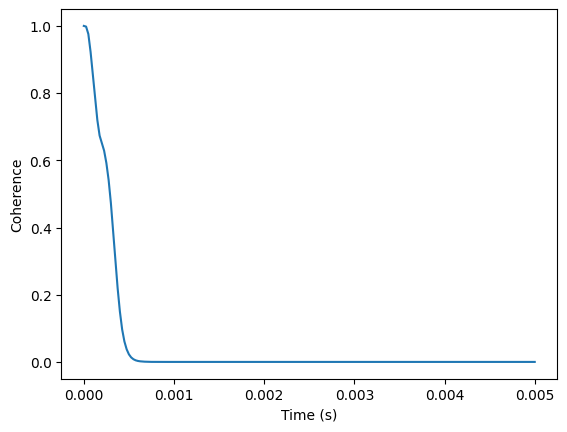

In [81]:
plt.figure()
plt.plot(calc_parameters[0.02]['timespace'], result.real)

plt.xlabel('Time (s)')
plt.ylabel('Coherence')
plt.show()

In [73]:
# # Simulation parameters
# nb=250
# ts = np.linspace(0, 5e-3, 201) #expected T2 of 3.3e-2
# # pulse_sequence = [pc.Pulse('x', np.pi)]

# #dictionary of parameters
# parameters = dict(
#     order=2, # CCE order
#     r_bath=100,  # Size of the bath in A
#     r_dipole=60,  # Cutoff of pairwise clusters in A
#     pulses = 1, # N pulses in CPMG sequence
#     magnetic_field=[0,0,10000] #set to 1T
# ) 

In [74]:
orders = runner('order', [2], pulse_sequence=1, nb=250, magnetic_field=[0,0,10000])
orders.plot(title='convergence test for orders',
           xlabel='time', ylabel='Coherence')
plt.show()  # uncomment to show individually

NameError: name 'runner' is not defined

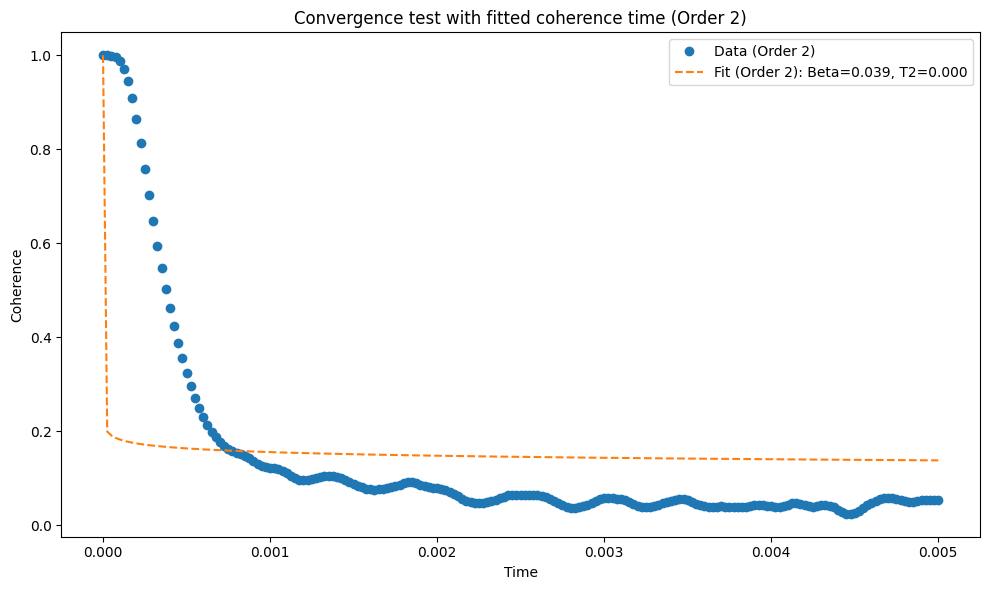

Fitted Betas: [0.03877439702612964]
Fitted T2s: [2.2589978308119967e-10]


In [ ]:
def coherence_time_func(time, beta, T2): # from cathal hogan code?
    y = np.exp(-(((2*time)/T2)**beta))
    return y


# Initialize lists to store fitted parameters for each order
betas = []
T2s = []

# Loop over each order (column in the 'orders' DataFrame)
for order in orders.columns:
    # Create a new figure for this order
    plt.figure(figsize=(10,6))
    
    # Truncate the data
    truncated_data = orders[orders.index <= 0.1]
    ydata = truncated_data[order]
    
    # Fit the data for the current order
    try:
        params, _ = curve_fit(coherence_time_func, truncated_data.index, ydata, maxfev=5000, bounds=([0, -np.inf], [np.inf, np.inf]))
        # params, _ = curve_fit(coherence_time_func, truncated_data.index, ydata, maxfev=5000)
        beta_fit, T2_fit = params
        betas.append(beta_fit)
        T2s.append(T2_fit)
        
        # Plotting original data and fit for the current order
        plt.plot(truncated_data.index, ydata, 'o', label=f'Data (Order {order})')
        plt.plot(truncated_data.index, coherence_time_func(truncated_data.index, *params), '--', 
                 label=f'Fit (Order {order}): Beta={beta_fit:.3f}, T2={T2_fit:.3f}')
        
        plt.title(f'Convergence test with fitted coherence time (Order {order})')
        plt.xlabel('Time')
        plt.ylabel('Coherence')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit for order {order} failed: {e}")
        betas.append(np.nan)
        T2s.append(np.nan)

# Display results
print("Fitted Betas:", betas)
print("Fitted T2s:", T2s)


In [ ]:
# #converge for order 
# orders = runner('order', [1,2,3])
# orders.plot(title='convergence test for orders; cell=75; nbstates=0; [?:20:10]',
#            xlabel='order', ylabel='Coherence')
# plt.show()  # uncomment to show individually

In [ ]:
####### 0.05 A to 0.8 A
# step 
# 0.1 to 1 A